In [ ]:
import matplotlib.pyplot as plt

from utils import *

## Loading dataset

In [ ]:
data = load_data("data_drop.csv")
columns_cookbook = load_data("owid-co2-codebook.csv")

In [ ]:
data.columns

In [ ]:
cols_desc_dict = get_cols_description(columns_cookbook)

In [ ]:
cols_desc_dict["co2"]

In [ ]:
data.shape

# Exploratory Analysis

### Number of countries per Continent

In [ ]:
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(2,1,1)
plot_number_of_countries_by_continent(data, ax=ax)
ax = fig.add_subplot(2,1,2)
plot_number_observations_by_country(data, ax=ax)

In [ ]:
data[data["continent"] == "South America"]["country"].unique()

### Number of observations per country

In [ ]:
data.groupby(["continent", "country"]).size().mean()

In [ ]:
data.groupby("country").size()

In [ ]:
data.groupby(["country","year"]).size()

In [ ]:
data.groupby(["continent","country", "year"]).agg("sum")

In [ ]:
us_data = get_observed_values_by_country(data, "United States")

In [ ]:
us_data

# Question 0

Who are the top emittors per continent?

In [ ]:
fig = plt.figure(figsize=(12, 15))
ax = fig.add_subplot(3,2,1)
plot_co2_emissions_by_continent(data, "North America", top=10, ax=ax)
ax = fig.add_subplot(3,2,2)
plot_co2_emissions_by_continent(data, "South America", top=10, ax=ax)
ax = fig.add_subplot(3,2,3)
plot_co2_emissions_by_continent(data, "Asia", top=10, ax=ax)
ax = fig.add_subplot(3,2,4)
plot_co2_emissions_by_continent(data, "Europe", top=10, ax=ax)
ax = fig.add_subplot(3,2,5)
plot_co2_emissions_by_continent(data, "Africa", top=10, ax=ax)
ax = fig.add_subplot(3,2,6)
plot_co2_emissions_by_continent(data, "Oceania", top=10, ax=ax)

In [ ]:
plot_corr_heatmap(data)
plt.title("Initial corr heatmap")
plt.savefig(f"plots/{plt.gcf().axes[0].get_title()}.png", bbox_inches="tight")

#### Alex Analysis

First, I want to assess the multicollinearity of the features to help me decide which to remove. To accomplish this, I will look at variance inflation factors, which are only defined for numeric variables. So, I will drop the categorical columns and create a new dataframe with only numeric data.

In [ ]:
data.dtypes

To compute variance inflation factors, I need to only consider numeric data. So I create a new dataframe with only the numeric data.

In [ ]:
numeric_data = data.drop(['country','iso_code','continent'], axis=1)

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["feature"] = numeric_data.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(numeric_data.values, i)
                          for i in range(len(numeric_data.columns))]

vif_data 

In [ ]:
vif_data[vif_data.VIF >= 500].feature.tolist()

I'll now create a correlation map of those variables with particularly high VIFs, so that I can assess which I'd like to remove for the final analysis.

In [ ]:
plot_corr_heatmap(data.loc[:, vif_data[vif_data.VIF >= 500].feature.tolist()])
plt.title("High Vif Corr Heatmap")
plt.savefig(f"plots/{plt.gcf().axes[0].get_title()}.png", bbox_inches="tight")

It's unsurprising that CO2 emissions are highly correlated with cumulative CO2 and CO2 emitted from different sources. Similarly, it's unsurprising that the share of overall global CO2 is highly correlated with cumulative global share, both overall and from different sources. Since all of these variables could be considered interesting responses, I am only going to keep overall CO2 emissions and the share of global CO2 emissions, and drop the rest.

In [ ]:
data = data.drop(['co2_per_capita',
                 'coal_co2',
                 'cumulative_co2',
                 'cumulative_coal_co2',
                 'cumulative_gas_co2',
                 'cumulative_oil_co2',
                 'gas_co2',
                 'oil_co2',
                 'share_global_coal_co2',
                 'share_global_cumulative_co2',
                 'share_global_cumulative_coal_co2',
                 'share_global_cumulative_oil_co2',
                 'share_global_oil_co2'], axis=1)

In [ ]:
plot_corr_heatmap(data)
plt.title("Low Vif Corr Heatmap")
plt.savefig(f"plots/{plt.gcf().axes[0].get_title()}.png", bbox_inches="tight")

Using this heatmap, I can also see that there are many more variables that are still parts of the CO2 whole, even though they do not have particularly high VIFs. I will remove these as well, because I am interested in total CO2 emissions rather than the composition of CO2 emissions.

In [ ]:
data = data.drop(['cement_co2', 'cement_co2_per_capita', 'co2_growth_abs',
                  'coal_co2_per_capita', 'cumulative_cement_co2', 'gas_co2_per_capita',
                  'oil_co2_per_capita', 'share_global_cement_co2', 'share_global_co2',
                  'share_global_cumulative_cement_co2', 'share_global_cumulative_gas_co2',
                  'share_global_gas_co2'], axis=1)

In [ ]:
plot_corr_heatmap(data)
plt.title("Final Features Corr Heatmap")
plt.savefig(f"plots/{plt.gcf().axes[0].get_title()}.png", bbox_inches="tight")

In [ ]:
data.to_csv("final_data.csv")

Now that I've picked out only the variables that I'm interested in keeping in my analysis, I want to use the data to answer a few questions.

### distribution of variables

In [ ]:
sns.pairplot(data.loc[:, ~data.columns.isin(['year','lat', 'long'])])
plt.show()

# Question 1

### Which countries from each continent has seen the greatest increases and decreases in CO2 efficiency from 2000 to 2018?

I will measure change in CO2 efficiency by looking at the percent change in `co2_per_unit_energy` from 2000 to 2018.

In [ ]:
# get countries that have observations in 2000 or 2018
data_2000 = data[data.year == 2000]
data_2018 = data[data.year == 2018]

# get list of countries that have observations in both years
common_countries = list(set(data_2000.country) & set(data_2018.country))

# stack dataframes 
data_2000_2018 = pd.concat(
    [data_2000[[country in common_countries for country in data_2000.country]],
    data_2018[[country in common_countries for country in data_2018.country]]]
).sort_values(['country', 'year'])

data_2000_2018

In [ ]:
# group with country and continent and get percent change
pct_change_co2_per_unit_energy = data_2000_2018.loc[:,['country','co2_per_unit_energy','continent']]\
                                    .groupby(['continent','country'], group_keys=True)\
                                    .apply(pd.Series.pct_change)\
                                    .dropna().reset_index().drop('level_2', axis=1)

Here are the countries with the greatest increase in CO2 efficiency (largest % drop in CO2 per unit energy):

In [ ]:
pct_change_co2_per_unit_energy.sort_values('co2_per_unit_energy').groupby(['continent']).head(1)

In [ ]:
sns.lineplot(data=data[[country in ['Hong Kong', 'North Macedonia', 'Nigeria', 'Peru', 'Mexico', 'Australia']
                       for country in data.country.tolist()]][data.year >= 2000],
             x='year', y='co2_per_unit_energy', hue='country')
plt.title('Countries with greatest reduction in CO2 per unit energy')
plt.ylabel('CO2 per unit energy')
plt.legend(bbox_to_anchor=(1.35, 1.05))
plt.savefig(f"plots/{plt.gcf().axes[0].get_title()}.png", bbox_inches="tight")
plt.show()

And here are the countries with the smallest increase (or decrease) in CO2 efficiency:

In [ ]:
pct_change_co2_per_unit_energy.sort_values('co2_per_unit_energy', ascending=False).groupby(['continent']).head(1)

In [ ]:
sns.lineplot(data=data[[country in ['Tajikistan', 'Bosnia and Herzegovina', 'South Africa', 'New Zealand', 'Chile', 'Canada']
                       for country in data.country.tolist()]][data.year >= 2000],
             x='year', y='co2_per_unit_energy', hue='country')
plt.title('Countries with least reduction in CO2 per unit energy')
plt.ylabel('CO2 per unit energy')
plt.legend(bbox_to_anchor=(1.0, 1.05))
plt.savefig(f"plots/{plt.gcf().axes[0].get_title()}.png", bbox_inches="tight")
plt.show()

# Question 2

### What is the relationship between population and CO2 emission?

First, we will look at the relationship between population and CO2 emissions for all countries that had measurements in 2018.

In [ ]:
data_2018 = data[data.year == 2018]

sns.scatterplot(data=data_2018, x='population', y='co2')
plt.xlabel("Population")
plt.ylabel("CO2 Emissions")
plt.title("Emissions vs. Population in 2018")
plt.savefig(f"plots/{plt.gcf().axes[0].get_title()}.png", bbox_inches="tight")
plt.show()

Since this plot has some very clear outliers, unequal variances across the range of the data, and a positive relationship, we will try a log-log transformation.

In [ ]:
import copy

In [ ]:
data_2018_loglog = copy.copy(data_2018)
data_2018_loglog['population'] = np.log(data_2018_loglog['population'])
data_2018_loglog['co2'] = np.log(data_2018_loglog['co2'])

sns.scatterplot(data=data_2018_loglog, x='population', y='co2')
plt.xlabel("Log Population")
plt.ylabel("Log CO2 Emissions")
plt.title("Log-Log Emissions vs. Population in 2018")
plt.savefig(f"plots/{plt.gcf().axes[0].get_title()}.png", bbox_inches="tight")
plt.show()

Now that we have a linear, equal-variance relationship to learn, we can do linear regression and use the learned parameters to answer questions about the relationship between population and CO2 emissions.

In [ ]:
from sklearn import linear_model
regressor = linear_model.LinearRegression()
regressor.fit(data_2018_loglog['population'].values.reshape(-1,1),
              data_2018_loglog['co2'].values.reshape(-1,1))

In [ ]:
regressor.coef_

Because we used a log-log regression model, the interpretation of the model parameters is different than with an ordinary linear regression model. In this case, we see that in 2018, a country with 8.9% more people than another produced 10% more CO2 on average.

Lastly, we can plot the learned linear model and a 95% confidence interval on the slope.

In [ ]:
sns.regplot(data=data_2018_loglog, x='population', y='co2')
plt.xlabel("Log Population")
plt.ylabel("Log CO2 Emissions")
plt.title("Log-Log Emissions vs. Population in 2018 w. Trend Line")
plt.savefig(f"plots/{plt.gcf().axes[0].get_title()}.png", bbox_inches="tight")
plt.show()

# Question 3

### What is the relationship between GDP and CO2 emissions?

In [ ]:
sns.scatterplot(data=data_2018, x='gdp', y='co2')
plt.xlabel("GDP")
plt.ylabel("CO2 Emissions")
plt.title("Emissions vs. GDP in 2018")
plt.savefig(f"plots/{plt.gcf().axes[0].get_title()}.png", bbox_inches="tight")
plt.show()

Again, the log-log transform is appropriate.

In [ ]:
data_2018_loglog['gdp'] = np.log(data_2018_loglog['gdp'])

sns.scatterplot(data=data_2018_loglog, x='gdp', y='co2')
plt.xlabel("Log GDP")
plt.ylabel("Log CO2 Emissions")
plt.title("Log-Log CO2 Emissions vs. GDP in 2018")
plt.savefig(f"plots/{plt.gcf().axes[0].get_title()}.png", bbox_inches="tight")
plt.show()

In [ ]:
regressor = linear_model.LinearRegression()
regressor.fit(data_2018_loglog['gdp'].values.reshape(-1,1),
              data_2018_loglog['co2'].values.reshape(-1,1))

In [ ]:
regressor.coef_

This learned model parameter indicates that in 2018, countries with a 10.2% higher GDP than others contributed 10% more CO2 on average.

In [ ]:
sns.regplot(data=data_2018_loglog, x='gdp', y='co2')
plt.xlabel("Log GDP")
plt.ylabel("Log CO2 Emissions")
plt.title("Log-Log CO2 Emissions vs. GDP in 2018 w. Trend Line")
plt.savefig(f"plots/{plt.gcf().axes[0].get_title()}.png", bbox_inches="tight")
plt.show()

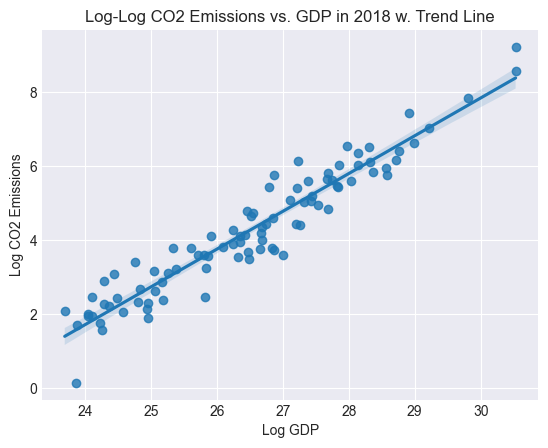

In [45]:
sns.regplot(data=data_2018_loglog, x='gdp', y='co2')
plt.xlabel("Log GDP")
plt.ylabel("Log CO2 Emissions")
plt.title("Log-Log CO2 Emissions vs. GDP in 2018 w. Trend Line")
plt.savefig(f"plots/{plt.gcf().axes[0].get_title()}.png", bbox_inches="tight")
plt.show()